In [28]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import plot_histogram

In [37]:
blackboxVal = '1001001110'

In [38]:
qCirc = QuantumCircuit(len(blackboxVal)+1, len(blackboxVal)) #one extra qubit for calculation

qCirc.h(range(len(blackboxVal)))

qCirc.x(len(blackboxVal))
qCirc.h(len(blackboxVal))

qCirc.barrier() # start blackbox

for i, val in enumerate(reversed(blackboxVal)):
    if val == '1':
        qCirc.cx(i, len(blackboxVal)) 

qCirc.barrier() # end blackbox

qCirc.h(range(len(blackboxVal)))

qCirc.measure(range(len(blackboxVal)), range(len(blackboxVal)))



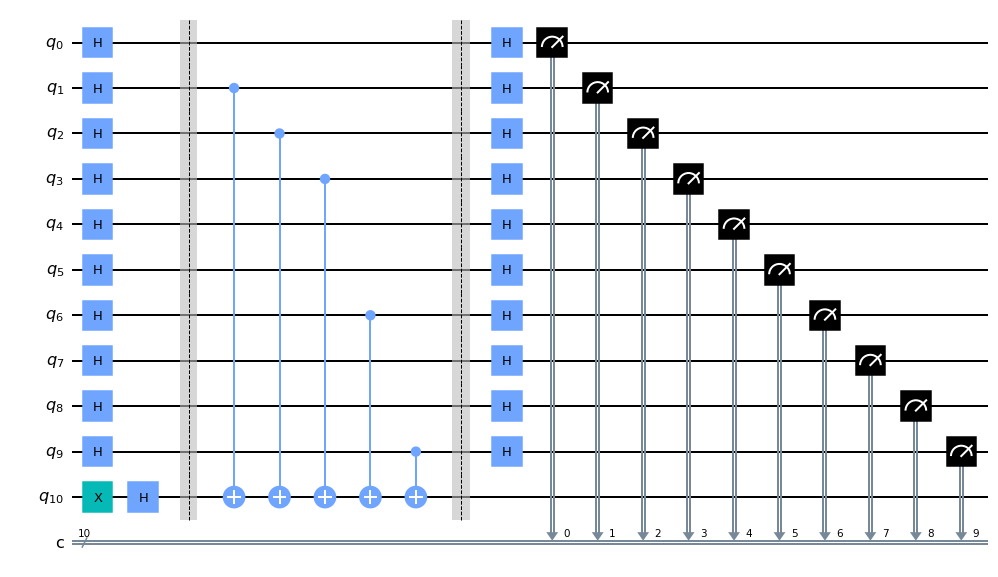

In [39]:
qCirc.draw(output='mpl')

In [40]:
sim = Aer.get_backend('qasm_simulator')
result = execute(qCirc, backend = sim, shots = 1).result() #result after one attempt
counts = result.get_counts()
print(counts)

{'1001001110': 1}
